In [2]:
import numpy as np
import numpy.random as nrand
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import uncertainties as unc
import uncertainties.unumpy as unp

In [3]:
landscape_dict = {'trna_Li':{},'trna_Domingo':{},'SD_seq':{}}
for model in ['trna_Li','trna_Domingo','SD_seq']:
    for metric in ['N_max','epi','r_s','open_ratio','E','gamma','adptwalk_steps','adptwalk_probs']:
        if model == 'trna_Li' and metric == 'E':
            continue
        with open(f'{model}/{model}_{metric}_plot.pkl','rb') as f:
            landscape_dict[model][metric] = pickle.load(f)

In [4]:
# Holling type III functional response model.

def func(x, a, b, c):
    return a*x**2/(a*b*x**2+1)+c

def cal_slope(x,a,b,c):
    x1 = x
    y1 = func(x,a,b,c)
    slope = a*b*np.exp(b*x)
    x0 = 0
    y0 = y1 - x*slope
    return x0,x1,y0,y1

In [5]:
def SSE(popt):
    return sum((func(np.array([1/np.sqrt(i) for i in range(1,N+1)]), *popt)-\
                np.array([np.mean(r_s_dict[i]) for i in range(1,N+1)]))**2)

In [15]:
ylim_dict =  {
    'trna_Li':{
        'N_max':[2450,2850],'epi':[0.07,0.11],
        'r_s':[2.5,5],'open_ratio':[0.05,0.15],
        'E':[0,1],'gamma':[0.475,0.625],
        'adptwalk_steps':[0.45,0.5], 'adptwalk_probs':[0.95,1.01]
              },
    'trna_Domingo':{
        'N_max':[30,200],'epi':[0.125,0.275],
        'r_s':[1.75,3],'open_ratio':[0.15,0.3],
        'E':[0.3,0.6],'gamma':[0.6,0.9],
        'adptwalk_steps':[0.25,0.4], 'adptwalk_probs':[0.9,1]
                   },
    'SD_seq':{
        'N_max':[0,5000],'epi':[0.11,0.28],
        'r_s':[3.8,4.6],'open_ratio':[0.05,0.6],
        'E':[0.775,0.85],'gamma':[0.55,0.75],
        'adptwalk_steps':[0.17,0.3], 'adptwalk_probs':[0.98,1.01]
    },
}

In [7]:
ruggedness_measure_dict = {'N_max':'$\mathit{N}_{max}$','epi':'$\mathit{F}_{rse}$','r_s':'$\mathit{r/s}$','open_ratio':'$\mathit{F}_{bp}$',
                           'E':'$\mathit{E}$','gamma':'$(1-\mathit{\gamma})$','adptwalk_steps':'$1/\mathit{N}_{adapt}$','adptwalk_probs':'$(1-\mathit{P}_{adapt})$'}

model_dict = {'trna_Li':"Li et al.'s landscape ",
              'trna_Domingo':"Domingo et al.'s landscape",
              'SD_seq':"Kuo et al.'s landscape"}

In [8]:
#metric_list = ['N_max','epi','r_s','open_ratio']
#metric_list = ['E','gamma','adptwalk_steps','adptwalk_probs']

2534
2517.721067594103
70
52.70679402192798
2404
3.7894419417895635e-13
0.08201775054979579
0.07932838510115568


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.17477691513583074
0.15497449591291212
0.21405786201212954
0.13559431241819764
3.3554625314021314
3.246132628560955
2.101833565552682
1.9640687538017847
4.063001723512898


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3.964794784014935
0.91574
0.5806322805506514
0.7444178090097098
0.7187431717749102
0.7737974295111663
0.4381441332809942


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


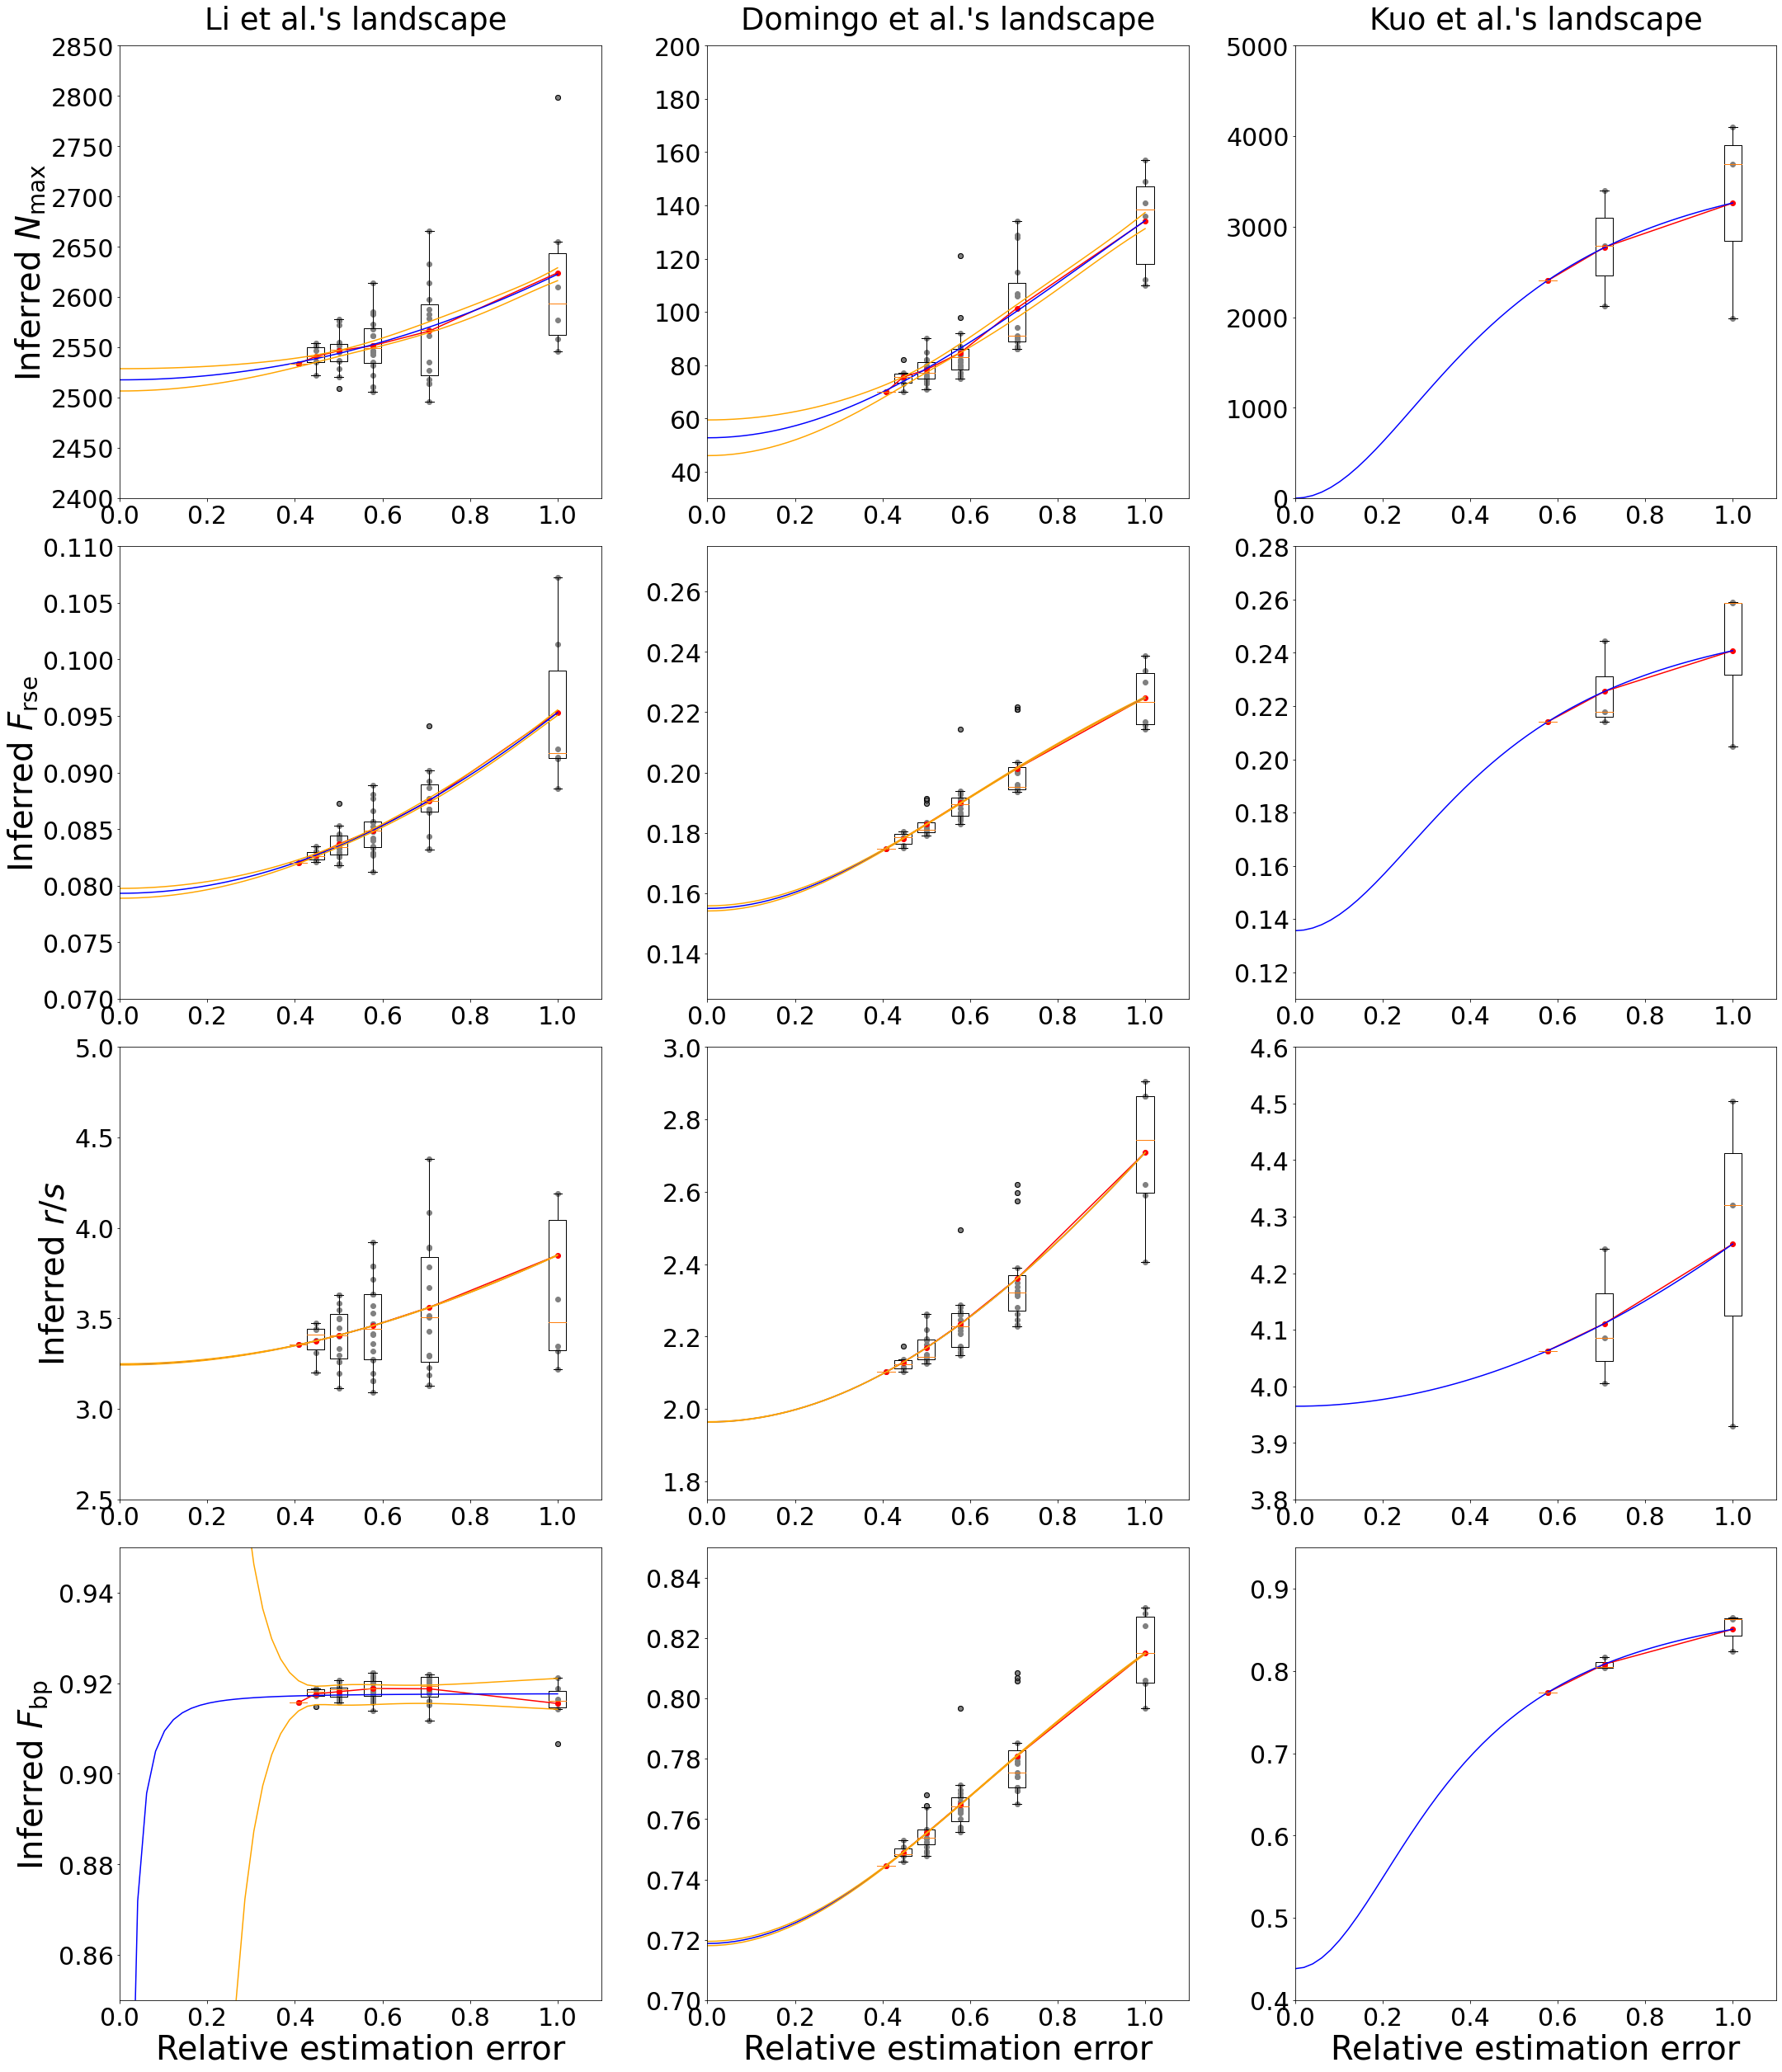

In [16]:
figure,axes = plt.subplots(4,3,figsize=[30,35])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for row,metric in enumerate(['N_max','epi','r_s','open_ratio']):
    for column,model in enumerate(['trna_Li','trna_Domingo','SD_seq']):
        ax = axes[row,column]
        N = len(landscape_dict[model][metric][1])
        
        if metric == 'open_ratio':
            r_s_dict = {}
            for i in range(1,1+N):
                r_s_dict[i] = [1-k for k in landscape_dict[model][metric][i]]
        else:
            r_s_dict = landscape_dict[model][metric]

        # fit curve
        xdata = [1/np.sqrt(i) for i in range(1,1+N)]
        ydata = [np.mean(r_s_dict[i]) for i in range(1,1+N)]

        popt_1, pcov_1 = curve_fit(func, xdata, ydata,maxfev=10000,bounds=([0,0,0],[np.inf,np.inf,np.inf]))
        popt_2, pcov_2 = curve_fit(func, xdata, ydata,maxfev=100000,bounds=([-np.inf,-np.inf,0],[0,0,np.inf]))
        if SSE(popt_1) < SSE(popt_2):
            popt = popt_1
            pcov = pcov_1
        else:
            popt = popt_2
            pcov = pcov_2
        
        # draw boxplot, dots, link line 
        for i in range(1,N+1):
            ax.scatter(x=[1/np.sqrt(i)]*len(r_s_dict[i]),y=r_s_dict[i],color="grey")
        ax.boxplot([r_s_dict[i] for i in range(1,1+N)],positions = [1/np.sqrt(i) for i in range(1,1+N)],widths=0.04)
        ax.plot([1/np.sqrt(i) for i in range(1,1+N)],[np.mean(r_s_dict[i]) for i in range(1,1+N)],'ro-')
        print(r_s_dict[N][0])
        
        # set pyplot parameters
        if model not in ['trna_Li','trna_Domingo','SD_seq']:
            ax.set_ylim(ylim_dict['Theoretical'][metric])
        else:
            if metric == 'open_ratio':
                ax.set_ylim([1-ylim_dict[model][metric][1],1-ylim_dict[model][metric][0]])
            else:
                ax.set_ylim(ylim_dict[model][metric])
        #if column == 0:
        
        
        ax.set_xlim(0,1.1)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.xaxis.set_tick_params(labelsize=30)
        ax.yaxis.set_tick_params(labelsize=30)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        #ax.set_xlabel(f'Relative estimation error',fontsize=40)
        if column == 0:
            ax.set_ylabel(f'Inferred {ruggedness_measure_dict[metric]}',fontsize=40)
        if row == 0: 
            ax.set_title(model_dict[model],fontsize=37,pad=20)
        if row == 3: 
            ax.set_xlabel(f'Relative estimation error',fontsize=40)
        
        # draw fitted curve
        ax.plot(np.linspace(0,1,50), func(np.linspace(0,1,50), *popt),
                 'b-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        
        print(func(0, *popt))
        # draw confidence bounds
        if N > 3:
            px = np.linspace(0,1,50)
            py = func(px, *unc.correlated_values(popt,pcov))
            nom = unp.nominal_values(py)
            std = unp.std_devs(py)

            ax.plot(np.linspace(0,1,50), nom+std*1.96,
                    color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

            ax.plot(np.linspace(0,1,50), nom-std*1.96,
                    color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.tight_layout(w_pad=4)
plt.savefig('result1.svg')

0.36993828
0.33618343535101336
0.80663496
0.804036827874431
0.5186237535284159
0.5069725247432952


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.7004695904014813
0.6615525785758365
0.6322335688578922
0.592301834960084
0.4680252986647927
0.46437251443936733
0.3007397641543983
0.28853380300570614
0.23290532353323143
0.20304217303709646


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.9886851136851137
0.062073502972374996
0.9870920603994154
3.766434825541301
0.999560057294864
1.0021505925646905


/home/siliang/usr/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


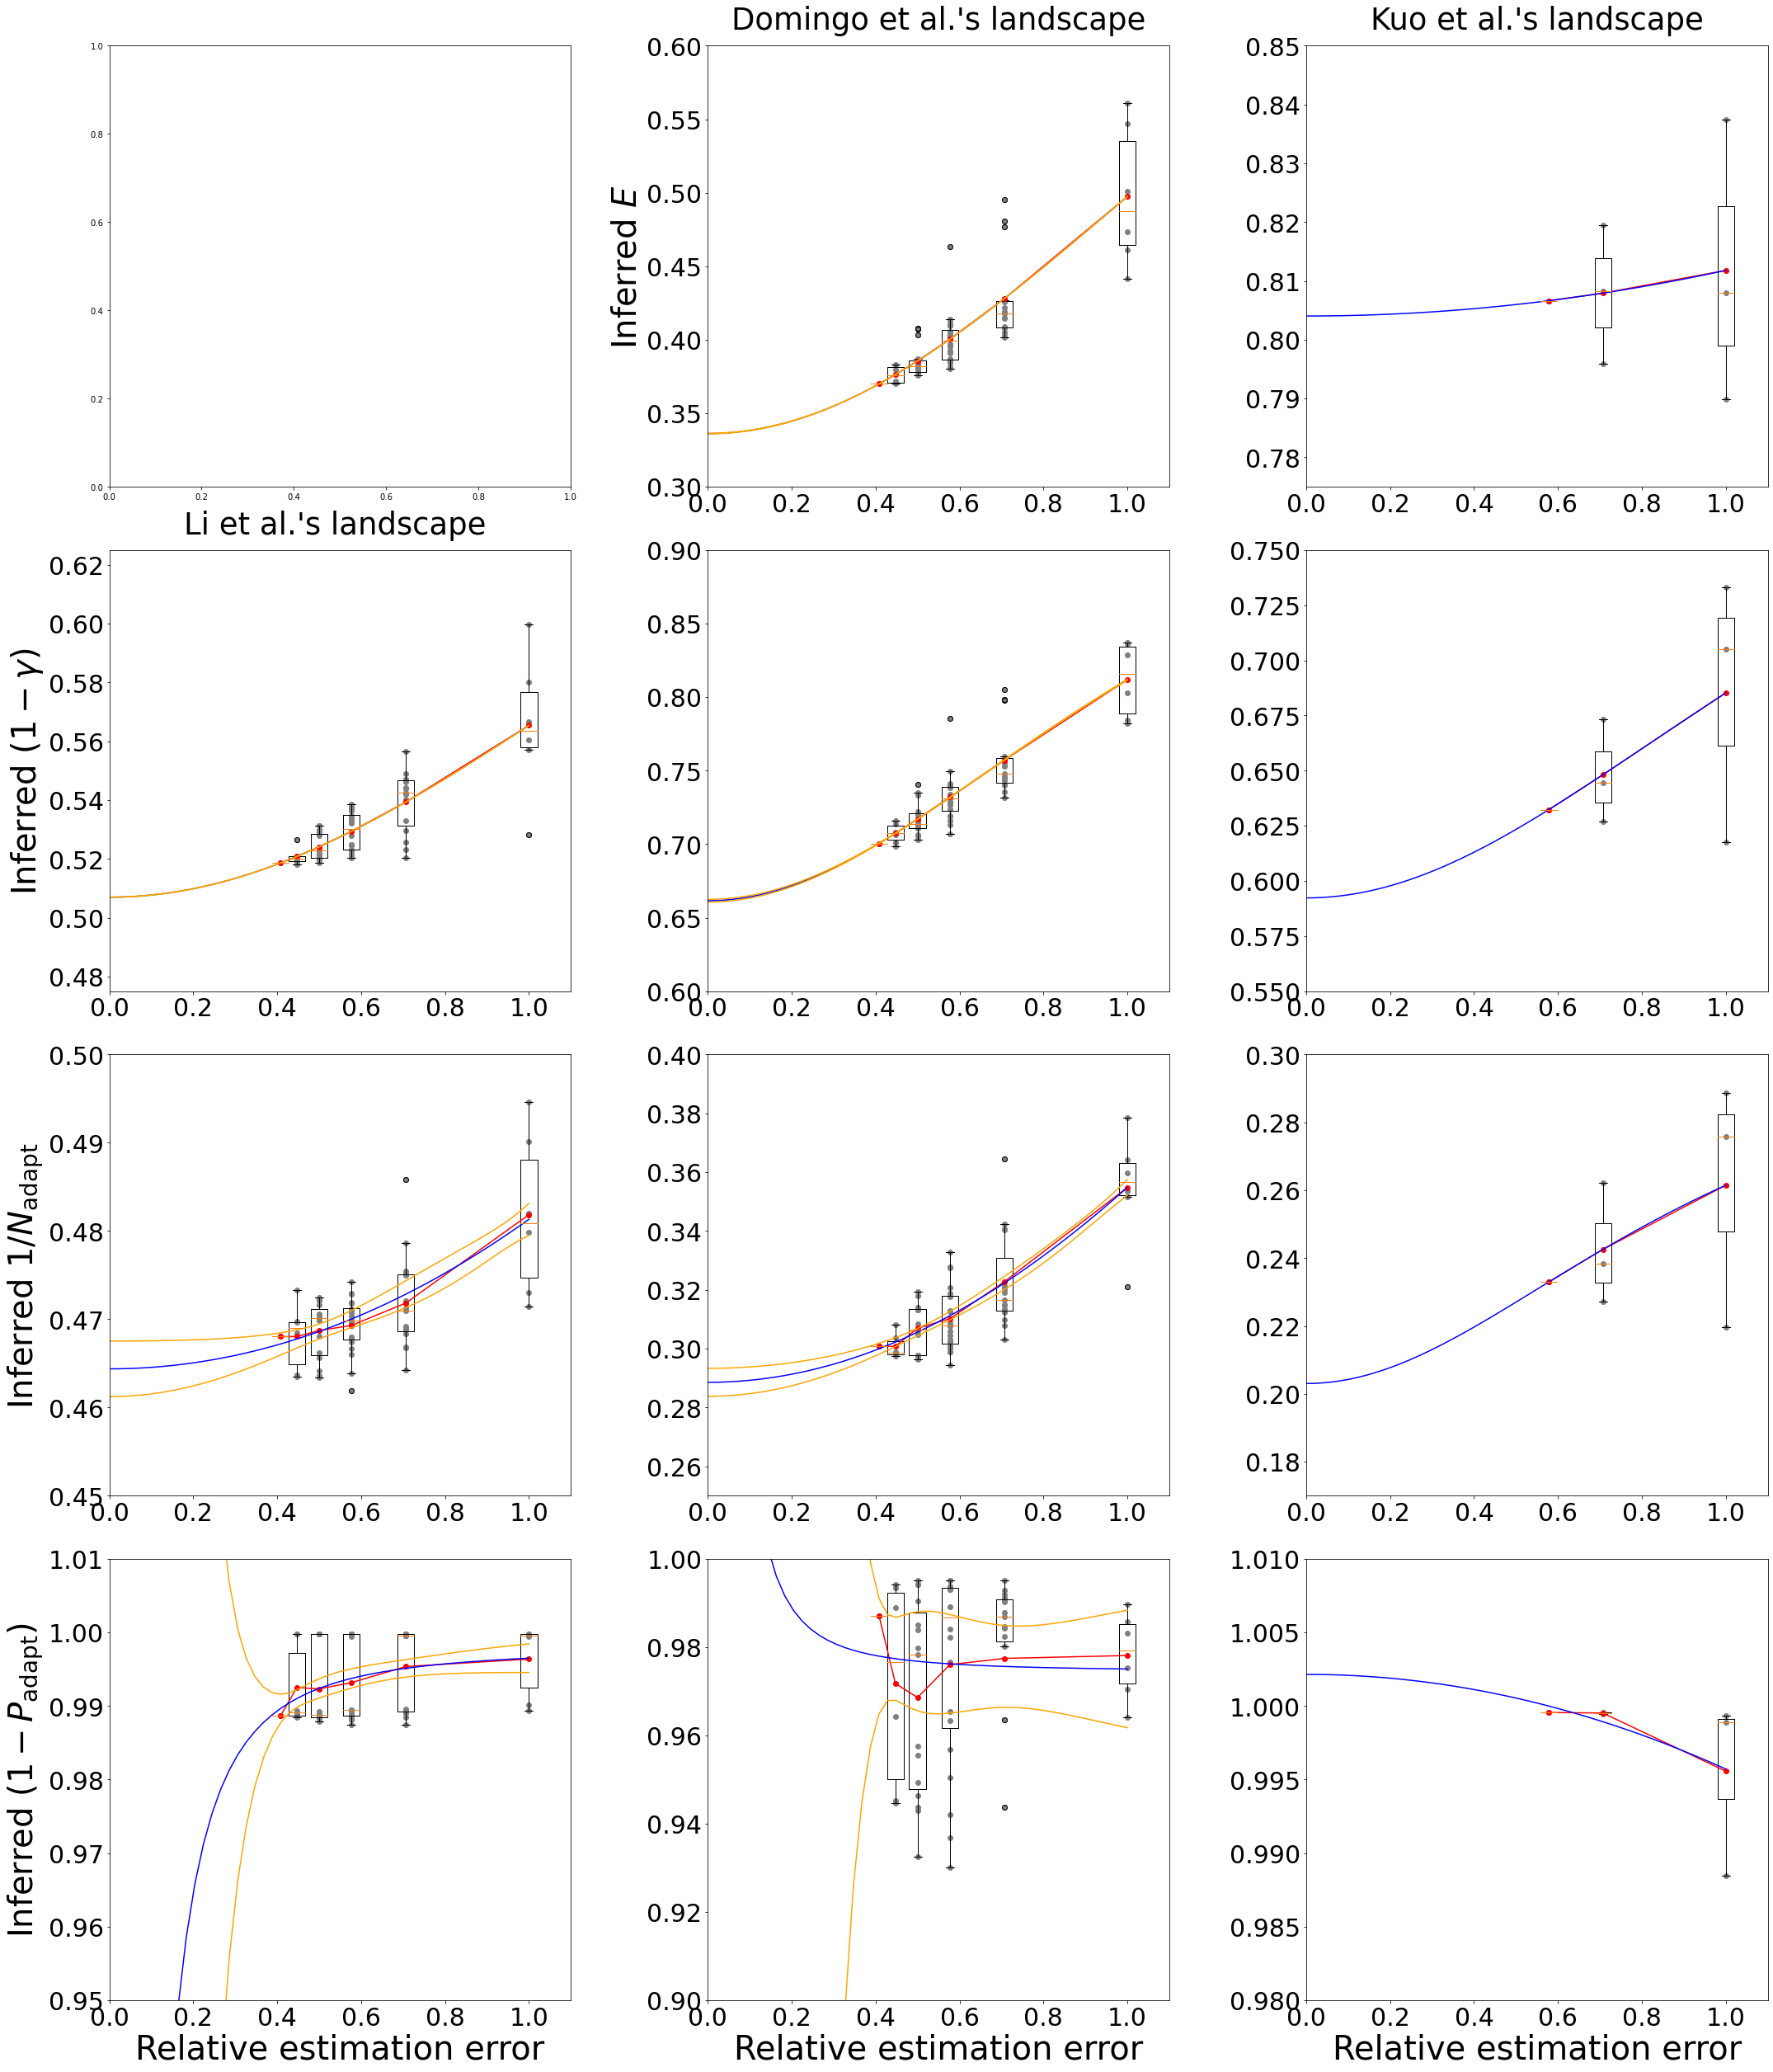

In [10]:
figure,axes = plt.subplots(4,3,figsize=[30,35])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

for row,metric in enumerate(['E','gamma','adptwalk_steps','adptwalk_probs']):
    for column,model in enumerate(['trna_Li','trna_Domingo','SD_seq']):
        
        if model == 'trna_Li' and metric == 'E': continue
        
        ax = axes[row,column]
        N = len(landscape_dict[model][metric][1])
        
        if metric in ['open_ratio','gamma','adptwalk_probs']:
            r_s_dict = {}
            for i in range(1,1+N):
                r_s_dict[i] = [1-k for k in landscape_dict[model][metric][i]]
        elif metric == 'adptwalk_steps':
            r_s_dict = {}
            for i in range(1,1+N):
                r_s_dict[i] = [1/k for k in landscape_dict[model][metric][i]]
        else:
            r_s_dict = landscape_dict[model][metric]

        # fit curve
        xdata = [1/np.sqrt(i) for i in range(1,1+N)]
        ydata = [np.mean(r_s_dict[i]) for i in range(1,1+N)]

        popt_1, pcov_1 = curve_fit(func, xdata, ydata,maxfev=10000,bounds=([0,0,0],[np.inf,np.inf,np.inf]))
        popt_2, pcov_2 = curve_fit(func, xdata, ydata,maxfev=100000,bounds=([-np.inf,-np.inf,0],[0,0,np.inf]))
        if SSE(popt_1) < SSE(popt_2):
            popt = popt_1
            pcov = pcov_1
        else:
            popt = popt_2
            pcov = pcov_2
        
        # draw boxplot, dots, link line 
        for i in range(1,N+1):
            ax.scatter(x=[1/np.sqrt(i)]*len(r_s_dict[i]),y=r_s_dict[i],color="grey")
        ax.boxplot([r_s_dict[i] for i in range(1,1+N)],positions = [1/np.sqrt(i) for i in range(1,1+N)],widths=0.04)
        ax.plot([1/np.sqrt(i) for i in range(1,1+N)],[np.mean(r_s_dict[i]) for i in range(1,1+N)],'ro-')
        print(r_s_dict[N][0])
        
        # set pyplot parameters
        if model not in ['trna_Li','trna_Domingo','SD_seq']:
            ax.set_ylim(ylim_dict['Theoretical'][metric])
        else:
            if metric == 'open_ratio':
                ax.set_ylim([1-ylim_dict[model][metric][1],1-ylim_dict[model][metric][0]])
            else:
                ax.set_ylim(ylim_dict[model][metric])
        #if column == 0:
        
        
        ax.set_xlim(0,1.1)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.xaxis.set_tick_params(labelsize=30)
        ax.yaxis.set_tick_params(labelsize=30)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        if (column == 0) or (column == 1 and row == 0):
            ax.set_ylabel(f'Inferred {ruggedness_measure_dict[metric]}',fontsize=40)
        if row == 0: 
            ax.set_title(model_dict[model],fontsize=37,pad=20)
        elif row == 3: 
            ax.set_xlabel(f'Relative estimation error',fontsize=40) 
        elif row == 1 and model == 'trna_Li':
            ax.set_title(model_dict[model],fontsize=37,pad=20)
        
        # draw fitted curve
        ax.plot(np.linspace(0,1,50), func(np.linspace(0,1,50), *popt),
                 'b-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        
        print(func(0, *popt))
        # draw confidence bounds
        if N > 3:
            px = np.linspace(0,1,50)
            py = func(px, *unc.correlated_values(popt,pcov))
            nom = unp.nominal_values(py)
            std = unp.std_devs(py)

            ax.plot(np.linspace(0,1,50), nom+std*1.96,
                    color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

            ax.plot(np.linspace(0,1,50), nom-std*1.96,
                    color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.tight_layout(w_pad=4)
plt.savefig('result2.svg')